# QUBO:  A Combination Approach of Graph Theory, Optimization, and Quantum Computing

This tutorial is designed for the beginner Qiskiter to gain insight in how graph theory, optimization, and quantum computing can be used to solve a QUBO problem. We do a deep dive into a basic implementation in Qiskit of a QUBO problem detailed in a PennyLane YouTube Tutorial. The video gives a great explanation of the problem and how to create the code.  There is a need to go into more detail on certain aspects of the problem and do analysis on the results, both which we aim to do here.  Here are the links to the PennyLane video and the corresponding code.

(https://www.youtube.com/watch?v=YJhv4bhNf6M)

(https://github.com/XanaduAI/PLC-YouTube-tutorials/blob/main/how_to_solve_qubo.ipynb)

## Objectives

1.  Understand how to formulate a QUBO problem
2.  Create a Hamiltonian operator based on the obtained objective function 
3.  Create a function to calculate the Hamiltonian using a parameterized quantum circuit 
4.  Use classical optimization algorithms to iterate the parameters to find the global minimum
5.  Perform 100 runs to check likelihood that a global minimum is reached
6.  Sample the circuit with the final parameters to find the quasi-distributions of each run
7.  Observe that not all runs achieve the global minimum
8.  Observe the symmetry of the optimal solutions and that due to phase shifts each solution has multiple optimal parameters
9.  Observe the superposition in runs that achieve a local minimum
9.  Explore one method to improve the likelihood of achieving the global minimum

The assumption during this tutorial is that the PennyLane video was watched.  We add some additional observations and clarifications throughout the notebook.


In [31]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# Added these libraries
import numpy as np
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import GradientDescent, GradientDescentState, SPSA, AQGD
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.opflow import I, X, Y, Z  # This library may be going away so need to add the latest library

np.set_printoptions(suppress=True) 

# Use this to try Runtime
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

# Problem Formulation

Using graph theory terminology, the formulation of the event scheduling problem as stated in the PennyLane video can be considered as the desire to find two independent sets of events such that every event is in one of the two sets but no two events in a set share an edge.  If such a pair exists, then every person will be able to attend their preferred events in two days. If no such independent set pair exists, then the optimal solution will have at least one person not attending an event on both days.


In [49]:
# From PennyLane:  H = - 6 * (I^I^I^I^I) + 0.5 * (Z^I^I^Z^I) + 0.5 * (I^Z^Z^I^I) + 0.5 * (I^I^I^Z^Z) + 0.5 * (I^I^Z^Z^I)
# Reversed the qubits for Qiskit
# Event 1 corresponds to qubit 0 and Event 5 corresponds to qubit 4
# Note that the qiskit.opflow library may be going away so need to add the latest library

H = - 6 * (I^I^I^I^I) + 0.5 * (I^Z^I^I^Z) + 0.5 * (I^I^Z^Z^I) + 0.5 * (Z^Z^I^I^I) + 0.5 * (I^Z^Z^I^I)   
print(H)
type(H)

-6.0 * IIIII
+ 0.5 * IZIIZ
+ 0.5 * IIZZI
+ 0.5 * ZZIII
+ 0.8 * IZZII


qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp

# Creation of the Hamiltonian and the Parameterized Quantum Circuit

Lecture 5.2 from the 2021 IBM Quantum Summer School gives a detailed derivation of the Hamiltonian from a generic quadratic objective function.  The derivation starts at the 10:49 mark of the video below and runs for about 8 minutes:

(https://youtu.be/YpLzSQPrgSc)

The change of variables from x's to z's is to exploit the eigenvalues of the Pauli matrices (-1 and 1) in order to create a function that calculates the expected value of the Hamiltonian.  Z gates are required in the Hamiltonian because the computational basis will be used to calculate the expectation of the operator.  To be clear, the qubits represent the events, not the attendees and to implement the circuit in Qiskit, the Hamiltonian is implemented here such that the order of the Z Gates lead to q0 corresponding to event 1 and q4 corresponding to event 5.   

When programming the circuit, the video does not give an explanation about why Ry gates are used over Rz or Rx gates.  In fact, Rx gates could be used as an alternative because they enable a qubit to move between 0 and 1 (think of the Bloch Sphere).  Try it. Rz gates, on the other hand, only change the phase so using strictly Rz gates would not allow for sufficient exploration of the state space.

## Test of the Expectation of the Hamiltonian and the Explanation of the Results

In the PennyLane video, the initial test example sets the parameters to zero.  As a result, all the Ry gates are performing rotations of zero degrees.  Since the initial state has all qubits in the zero state, the final state will have all qubits in the the zero state because effectively no rotations were performed.  As a result, all events will be held on Saturday and each person can only attend one event so the total number of events attended is 4 which is equivalent to an expectation value of -4 for the Hamiltonian.

Note that the minimum possible value of the Hamiltonian is -8 and occurs only if there is a way that each of the 4 attendees can attend their 2 events.

In [50]:
#Initial test assuming no rotation angles so each qubit will be unchanged after applying the Ry gates
#qubo_circuit, by returning the value of the Hamiltonian, is the function that will be optimized 

params = [0,0,0,0,0] #initial rotation angles

estimator = Estimator()

def qubo_circuit(params):
    #print(params)
    qubo_c = QuantumCircuit(5)
    for i in range(5):
        qubo_c.rx(params[i], i)
    return estimator.run(qubo_c, H).result().values[0]

expectation_value = qubo_circuit(params)

print("expectation: ", expectation_value)


expectation:  -3.7


# Optimization

While a QUBO is a quadratic optimization function, it is not guaranteed to obtain the global minimum from gradient methods because the variables are not continuous but are, in fact, discrete (binary).

The qubo_circuit function returns the value of the Hamiltonian for a given set of parameters.  In performing an optimization, a gradient method uses finite difference calculations to determine the next direction of exploration until the maximum number of iterations is reached or a tolerance threshold is achieved.

Perform 100 runs, each starting with a set of random parameters to determine what percentage converge to the global minimum.  The gradient descent algorithm converges very slowly but the SPSA algorithm provides convergence within a reasonable time frame.  Store the final parameters and expectation values of the Hamiltonian for each run to perform additional analysis.  


In [51]:
fp = [] # final parameters for each iteration
exp_val = [] # expected value for each iteration
#np.random.seed(0)  # Uncomment if you want to run the same seed (Only useful when using deterministic optimization algorithms)
num = 100
for i in range (num):
    params = 2*np.pi*np.random.rand(5) - np.pi #initial random rotation angles between -pi and pi to create more balance between mirror states
    print("Run: ", i)

    # Gradient Descent converges very slowly.  Need to increase the step size.
    #optimizer = GradientDescent(maxiter=800)
    #result = optimizer.minimize(fun=qubo_circuit, x0=params)

    # SPSA is fast
    optimizer = SPSA(maxiter=500)
    result = optimizer.minimize(fun=qubo_circuit,x0=params)

    # I haven't been able to get AQGD to work
    #optimizer = AQGD(maxiter=200, eta=2.0)
    #result = optimizer.minimize(fun=qubo_circuit,x0=params)

    print(f"Found minimum {np.round(result.x, 4)} at a value of {np.round(result.fun, 4)} using {result.nfev} evaluations.")
    params_f = np.ndarray.round(result.x,4)
    fp.append(params_f)
    exp_val.append(result.fun)

Run:  0
Found minimum [0.     3.1416 0.     3.1416 0.    ] at a value of -8.3 using 1000 evaluations.
Run:  1
Found minimum [-3.1416  0.      3.1416 -0.      3.1416] at a value of -8.3 using 1000 evaluations.
Run:  2
Found minimum [-3.1411  6.2812  3.1417 -0.     -3.1417] at a value of -8.3 using 1000 evaluations.
Run:  3
Found minimum [ 3.1395  0.     -3.1417 -0.     -3.1437] at a value of -8.3 using 1000 evaluations.
Run:  4
Found minimum [ 3.1416 -6.2832 -3.1416 -0.      3.1416] at a value of -8.3 using 1000 evaluations.
Run:  5
Found minimum [ 6.2832  3.1416  0.     -3.1416 -0.    ] at a value of -8.3 using 1000 evaluations.
Run:  6
Found minimum [-3.1416 -0.      3.1416 -0.     -3.1416] at a value of -8.3 using 1000 evaluations.
Run:  7
Found minimum [-0.0006  3.1154  0.0014  3.1436 -0.0039] at a value of -8.2998 using 1000 evaluations.
Run:  8
Found minimum [-0.     -3.1416  0.     -3.1416  0.    ] at a value of -8.3 using 1000 evaluations.
Run:  9
Found minimum [-0.0006 -3.1402 

# Quasi-distributions

Notice from the above output that when a value near -8 is achieved that either events 2 and 4 under go a rotation approaching + or - pi or events 1, 3, and 5 under go a rotation approaching + or - pi.  This observation makes sense as such an ry gate rotation flips a qubit from the 0 state to the 1 state.  Also, note that a parameter value of + or - 6.28 approximates 2 times pi which will have a rotation of zero.  We do further analysis discussed below.

We use Qiskit's Sampler to perform 1000 measurements on each of the 100 runs to find the quasi distributions of each run.  The output is python dictionary the keys being the decimal representation of bit streams, and values being the realized probabilities.  Note that the decimal representations of the classical bit streams will range between 0 and 31 to represent which of the five events take place on Sunday (bit value 1) or Saturday (bit value 0).  For example, a bit stream value for 10 is 01010 which occurs when events 2 and 4 occur on Sunday and events 1, 3, and 5 occcur on Saturday.

In [52]:
sampler = Sampler()

def qubo_circuit_sample(params):
    qubo_c = QuantumCircuit(5,5)
    for i in range(5):
        qubo_c.rx(params[i], i)
        qubo_c.measure([i],[i])
    qubo_c.draw('mpl')
    job = sampler.run(qubo_c, shots=1000)
    return job.result()

sample_val=[]
for i in range(num):
    sample_val.append(qubo_circuit_sample(fp[i]))
    if i%10 == 9:
        print("Iter:  ", i)

Iter:   9
Iter:   19
Iter:   29
Iter:   39
Iter:   49
Iter:   59
Iter:   69
Iter:   79
Iter:   89
Iter:   99


Run:   66    Exp Val:   -6.75       Quasi Dist:   [{17: 0.002, 19: 0.909, 23: 0.089}]


(array([99.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-8.3  , -8.145, -7.99 , -7.835, -7.68 , -7.525, -7.37 , -7.215,
        -7.06 , -6.905, -6.75 ]),
 <BarContainer object of 10 artists>)

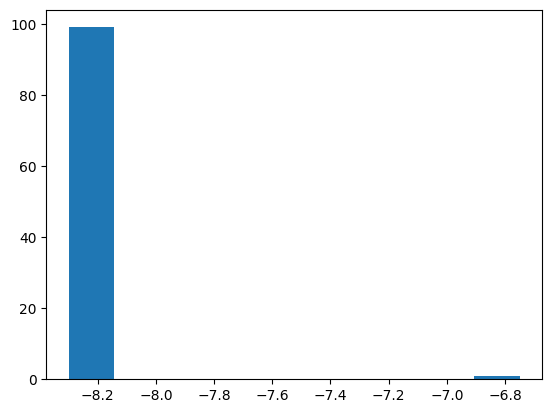

In [53]:
exp_val_short=[]
for i in range(num):
    if (exp_val[i] > -7.5):  # currently prints out runs stuck in a local minimum
        print("Run:  ", i,"   Exp Val:  ", np.round(exp_val[i],2), "      Quasi Dist:  ", sample_val[i].quasi_dists)
    exp_val_short.append(np.round(exp_val[i],2))

plt.hist(exp_val_short)

# Analysis

Recall that attendee 1 prefers events 1 and 4, attendee 2 prefers events 2 and 3, attendee 3 prefers events 3 and 4, and attendee 4 prefers events 4 and 5.

See the table of 1) sample decimal values of the classical bit streams with a range of 0 - 31 corresponding to the 5 bits associated with the 5 events, 2) the associated Hamiltonian value, and 3) the events to be held on Sunday for that decimal value.

| Decimal Value of Bit Stream |   Hamiltonian Value (-) |  Events on Sunday |
| --- | ---- | ---- |
| 5 (00101) |              7 |                3, 1 |
| 8 (01000) |             7  |                4 |
| 10 (01010) |             8 |                4, 2 |
| 11 (01011) |             7 |                4, 2, 1 |
| 12 (01100) |             7 |                4, 3 |
| 14 (01110) |             6 |                4, 3, 2 |
| 19 (10011) |             7 |                5, 2, 1  |
| 20 (10100) |             7 |                5, 3 |
| 21 (10101) |             8 |                5, 3, 1 |
| 23 (10111) |             7 |                5, 3, 2, 1 |
| 26 (11011) |             7 |                5, 4, 2 |


## Global minimum

Since the maximum number of events that can be attended by the four attendees is also 8, we know that we have achieved a global minimum if expected value of Hamiltonian of -8 is obtained.  In the 100 runs, this global minimum is reached roughly 75% of the time.  This expectation value is reached when events 2 and 4 occur together on Sunday and events 1, 3, and 5 occur on Saturday.  This occurence corresponds to a bit stream value of 10 (01010).

In order to study the runs that do not attain the global minimums in more detail, the current output only prints the quasi distributions of runs with an expected value > -7.5 which one can modify as desired.  The histogram does include all 100 runs.

## Symmetry

Note that the mirror solution of having events 1, 3, and 5 occur on Sunday with a bit stream value of 21 (10101) also attains an expected value of -8.  The mirror of each classical bit stream output is its difference from 31.  For example, an output of 10 corresponds to events 2 and 4 being held on Sunday and its mirror is 31 - 10 = 21 which corresponded to events 1, 3, and 5 being held on Sunday.  The two solutions are equivalent to the problem as formulated.The problem always has two solutions because the mirror one could just flip the events on Saturday and Sunday to obtain the same expectation value of the Hamiltonian.

## Phase shifts

There are multiple possible ry gate combinations (final parameter settings) that can yield the same bit stream value.  As an example, ry gate rotations of pi and -pi will yield opposite probability amplitudes but the same measurement probabilities.

## Quantum phenonmena or rounding error?

It is interesting to observe that even when the global minimum is reached there are some runs that have some non-zero quasi probability of not attaining that minimum.  This may due to the optimization algorithm timing out at its maximum iteration count or due to rounding error in the final parameters of the rotation gates specifically because pi is an irrational number.

However, for the runs that attain a local minimum value near 7, we do observe that most have a quasi distribution that is split between a decimal state of 8 (only event 4 on Sunday) and 12 (only events 3 and 4 on Sunday) with both having significant non-zero probabilities.  This suggests that in most local minimums there is superposition between at least two two event states at these local minimums.

The observation that the quasi probabilities between states 8 and 12 appear to vary significantly between the local minimum runs requires further thought.  State 12 generally has a higher quasi probability than state 8 which may make sense as there are probably more descent paths leading to events 3 and 4 happening on Sunday than only event 4 happening on Sunday.

What was intially observed was that the mirror of this superposition which would be a superposition of 19 and 23 occured much less frequently which warranted further investigation.  The initial random parameters were being chosen from (0, 1) but, to be distributed across the entire state space, the range should be between (-pi, pi).  This appeared to fix the the frequency imbalance between mirror superpostion states.  To add further randomness, one could also randomize the initial starting state for each run.
    
# Modification of the Hamiltonian to Obtain more Global Minimum Runs

Let's think about the original problem to gain some insight to see how we can modify the Hamiltonian to achieve better results.  Looking at the objective function before the variable transformation from x's to z's, notice that event 3 and event 4 are in the highest demand by the attendees.  So we would want to place these events on separate days.  Since there is one attendee that wants to go to both events, we can simply increase the coefficient of this term in the Hamiltonian to reduce the chances of events 3 and 4 occur on the same day.   We are effectively adding a penalty to the objective function to account for the added constraint.  This is same technique as using Lagrangian coefficients in a traditional constrained optimization problem.  The table below shows that we do get our desired outcome as we increase the coefficient. 

| Coefficent | % at local minimums (approx) |
| ------ | ------ |
| 0.5 |      wide range 10-30 |
| 0.6 |      10 |
| 0.7 |      5  |
| 0.8 |      1  |

# Future areas of exploration

- Implement with RunTime to understand its benefits

- Use other Qiskit optimizers with the quantum circuit to improve the likelihood of attaining the global minimum or balancing out outcomes for local minimum runs.  Perhaps experimenting with the number of iterations or larger step sizes will help.

- Occasionally, a run gets finds a minimum reasonably greater than -8 and reasonably less than -7.  Investigate how this occurs and what it may mean.

- Gain further insight by creating variations to the original problem such as 1) introducing more attendees or events, or 2) adding constraints to certain events or attendees and adjusting the Hamiltonian appropriately

- Use other quantum algorithms to improve the likelihood of finding the global minimum.  Other methods could include quantum annealing or QAOA.  While it is difficult to perform quantum annealing within Qiskit, we can perform a QAOA implementation in hopes of improving the likelihood of achieving the global minimum.

- Run the circuit on an IBM Quantum Computer to understand the issues that arise from a noisy channel